![](../logo.png)

# Machine learning with Scikit-learn
## Yoav Ram

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import zipfile

import sklearn.datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import PredictionErrorDisplay

pd.set_option("display.max_columns", 1000)
sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

# Supervised learning

Supervised learning consists in learning the link between two datasets: the observed data `X` and an external variable `y` that we are trying to predict, usually called “target” or “labels”. Most often, `y` is a 1D array of length `n_samples`.

All supervised estimators in *scikit-learn* implement a `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

There are two fundamental supervised learning problems: regression and classification.
In regression, we need to predict a number.
In classification, we need to predict a (discrete) class.

We will now deal with regression, in which $Y$ can be any continous value.

$$
X \to Y
$$

# Tennis: predict points from aces

Let's download some tennis data so that we can talk about *linear regression*.

This data is from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.

We open the containing zip file and print its contents.

Note: [`zipfile`](https://docs.python.org/3/library/zipfile.html) is part of Python standard library, which also includes modules for [`gzip`](https://docs.python.org/3/library/gzip.html), [`bz2`](https://docs.python.org/3/library/bz2.html) and other compression formats.

In [3]:
filename = '../data/tennis.zip'

tennis_zip = zipfile.ZipFile(filename)
for f in tennis_zip.filelist: 
    print(f.filename)

data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


We open the data for Novak Djokovic.

In [5]:
player = 'Novak Djokovic'
path = 'data/{}.csv'
path = path.format(player.replace(' ', '-'))
with tennis_zip.open(path) as f:
    df = pd.read_csv(f)
df.tail()

year                  tournament  start date type        surface  \
725  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   
726  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   
727  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   
728  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   
729  2012  Australian Open, Australia  16.01.2012   GS  Outdoor: Hard   

          draw atp points  atp ranking tournament prize money round  \
725  Draw: 128      2,000          1.0            A$2,300,000   R32   
726  Draw: 128      2,000          1.0            A$2,300,000   R16   
727  Draw: 128      2,000          1.0            A$2,300,000     Q   
728  Draw: 128      2,000          1.0            A$2,300,000     S   
729  Draw: 128      2,000          1.0            A$2,300,000     W   

                 opponent ranking                         score  \
725   Nicolas Mahut (FRA)      81               W 6-0, 6-1, 6-1   
726  Lleyton Hewitt (AUS)     181          W 6-1, 6-3, 4-6, 6-3   
727    David Ferrer (ESP)       5            W 6-4, 7-6(4), 6-1   
728     Andy Murray (GBR)       4  W 6-3, 3-6, 6-7(4), 6-1, 7-5   
729    Rafael Nadal (ESP)       2  W 5-7, 6-4, 6-2, 6-7(5), 7-5   

                                            stats link     tournament.1  \
725  http://www.atpworldtour.com/Share/Match-Facts-...  Australian Open   
726  http://www.atpworldtour.com/Share/Match-Facts-...  Australian Open   
727  http://www.atpworldtour.com/Share/Match-Facts-...  Australian Open   
728  http://www.atpworldtour.com/Share/Match-Facts-...  Australian Open   
729  http://www.atpworldtour.com/Share/Match-Facts-...  Australian Open   

    tournament round  time          winner    player1 name  \
725              R32    74  Novak Djokovic  Novak Djokovic   
726              R16   176  Novak Djokovic  Novak Djokovic   
727                Q   164  Novak Djokovic  Novak Djokovic   
728                S   290  Novak Djokovic  Novak Djokovic   
729                F   353  Novak Djokovic  Novak Djokovic   

    player1 nationality  player1 aces  player1 double faults  \
725              Serbia           7.0                    1.0   
726              Serbia          15.0                    3.0   
727              Serbia           3.0                    0.0   
728              Serbia          11.0                    6.0   
729              Serbia           9.0                    2.0   

     player1 1st serves in  player1 1st serves total  \
725                   32.0                      52.0   
726                   63.0                     102.0   
727                   47.0                      91.0   
728                  104.0                     171.0   
729                   98.0                     166.0   

     player1 1st serve points won  player1 1st serve points total  \
725                          27.0                            32.0   
726                          46.0                            63.0   
727                          34.0                            47.0   
728                          69.0                           104.0   
729                          67.0                            98.0   

     player1 2nd serve points won  player1 2nd serve points total  \
725                          14.0                            20.0   
726                          22.0                            39.0   
727                          29.0                            44.0   
728                          30.0                            67.0   
729                          43.0                            68.0   

     player1 break points won  player1 break points total  \
725                       1.0                         1.0   
726                       2.0                         6.0   
727                       2.0                         4.0   
728                      17.0                        24.0   
729                       2.0                         6

We plot a scatterplot of aces and total points won, together with the distributions of each. the distributions seem smooth and the scatterplot does show a clear slope.

In [9]:
idx = df['player1 total points won'] > 150
df[idx]

year                  tournament  start date type         surface  \
67   2005         US Open, NY, U.S.A.  29.08.2005   GS   Outdoor: Hard   
74   2005          Wimbledon, England  20.06.2005   GS  Outdoor: Grass   
177  2007         US Open, NY, U.S.A.  27.08.2007   GS   Outdoor: Hard   
179  2007         US Open, NY, U.S.A.  27.08.2007   GS   Outdoor: Hard   
195  2007    Wimbledon, Great Britain  25.06.2007   GS  Outdoor: Grass   
196  2007    Wimbledon, Great Britain  25.06.2007   GS  Outdoor: Grass   
197  2007    Wimbledon, Great Britain  25.06.2007   GS  Outdoor: Grass   
204  2007       Roland Garros, France  28.05.2007   GS   Outdoor: Clay   
275  2008         US Open, NY, U.S.A.  25.08.2008   GS   Outdoor: Hard   
276  2008         US Open, NY, U.S.A.  25.08.2008   GS   Outdoor: Hard   
481  2010         US Open, NY, U.S.A.  30.08.2010   GS   Outdoor: Hard   
486  2010         US Open, NY, U.S.A.  30.08.2010   GS   Outdoor: Hard   
499  2010    Wimbledon, Great Britain  21.06.2010   GS  Outdoor: Grass   
512  2010       Roland Garros, France  24.05.2010   GS   Outdoor: Clay   
546  2010  Australian Open, Australia  18.01.2010   GS   Outdoor: Hard   
564  2011         US Open, NY, U.S.A.  29.08.2011   GS   Outdoor: Hard   
658  2012         US Open, NY, U.S.A.  27.08.2012   GS   Outdoor: Hard   
686  2012       Roland Garros, France  27.05.2012   GS   Outdoor: Clay   
687  2012       Roland Garros, France  27.05.2012   GS   Outdoor: Clay   
728  2012  Australian Open, Australia  16.01.2012   GS   Outdoor: Hard   
729  2012  Australian Open, Australia  16.01.2012   GS   Outdoor: Hard   

          draw atp points  atp ranking tournament prize money round  \
67   Draw: 128         75         97.0                $40,000  R128   
74   Draw: 128         90        128.0                $46,680   R64   
177  Draw: 128        700          3.0               $700,000   R64   
179  Draw: 128        700          3.0               $700,000   R16   
195  Draw: 128        450          5.0               $349,795   R32   
196  Draw: 128        450          5.0               $349,795   R16   
197  Draw: 128        450          5.0               $349,795     Q   
204  Draw: 128        450          6.0               $335,890   R32   
275  Draw: 128        900          3.0               $320,000   R32   
276  Draw: 128        900          3.0               $320,000   R16   
481  Draw: 128      1,200          3.0               $850,000  R128   
486  Draw: 128      1,200          3.0               $850,000     S   
499  Draw: 128        720          3.0                250,000  R128   
512  Draw: 128        360          3.0                140,000     Q   
546  Draw: 128        360          3.0              A$200,000     Q   
564  Draw: 128      2,000          1.0             $2,300,000     S   
658  Draw: 128      1,200          2.0             $1,450,000     F   
686  Draw: 128      1,200          1.0                625,000   R16   
687  Draw: 128      1,200          1.0                625,000     Q   
728  Draw: 128      2,000          1.0            A$2,300,000     S   
729  Draw: 128      2,000          1.0            A$2,300,000     W   

                         opponent ranking                               score  \
67             Gael Monfils (FRA)      43        W 7-5, 4-6, 7-6(5), 0-6, 7-5   
74   Guillermo Garcia-Lopez (ESP)      81     W 3-6, 3-6, 7-6(5), 7-6(3), 6-4   
177          Radek Stepanek (CZE)      35  W 6-7(4), 7-6(5), 5-7, 7-5, 7-6(2)   
179             Juan Monaco (ARG)      23          W 7-5, 7-6(2), 6-7(6), 6-1   
195          Nicolas Kiefer (GER)     NaN       W 7-6(4), 6-7(6), 6-2, 7-6(5)   
196          Lleyton Hewitt (AUS)      19       W 7-6(8), 7-6(2), 4-6, 7-6(5)   
197        Marcos Baghdatis (CYP)      16  W 7-6(4), 7-6(9), 6-7(3), 4-6, 7-5   
204        Olivier Patience (FRA)     129     W 7-6(2), 2-6, 3-6, 7-6(4), 6-3   
275             Marin Cilic (CRO)      24          W 6-7(7), 7-5, 6-4, 7-6(0)   
276

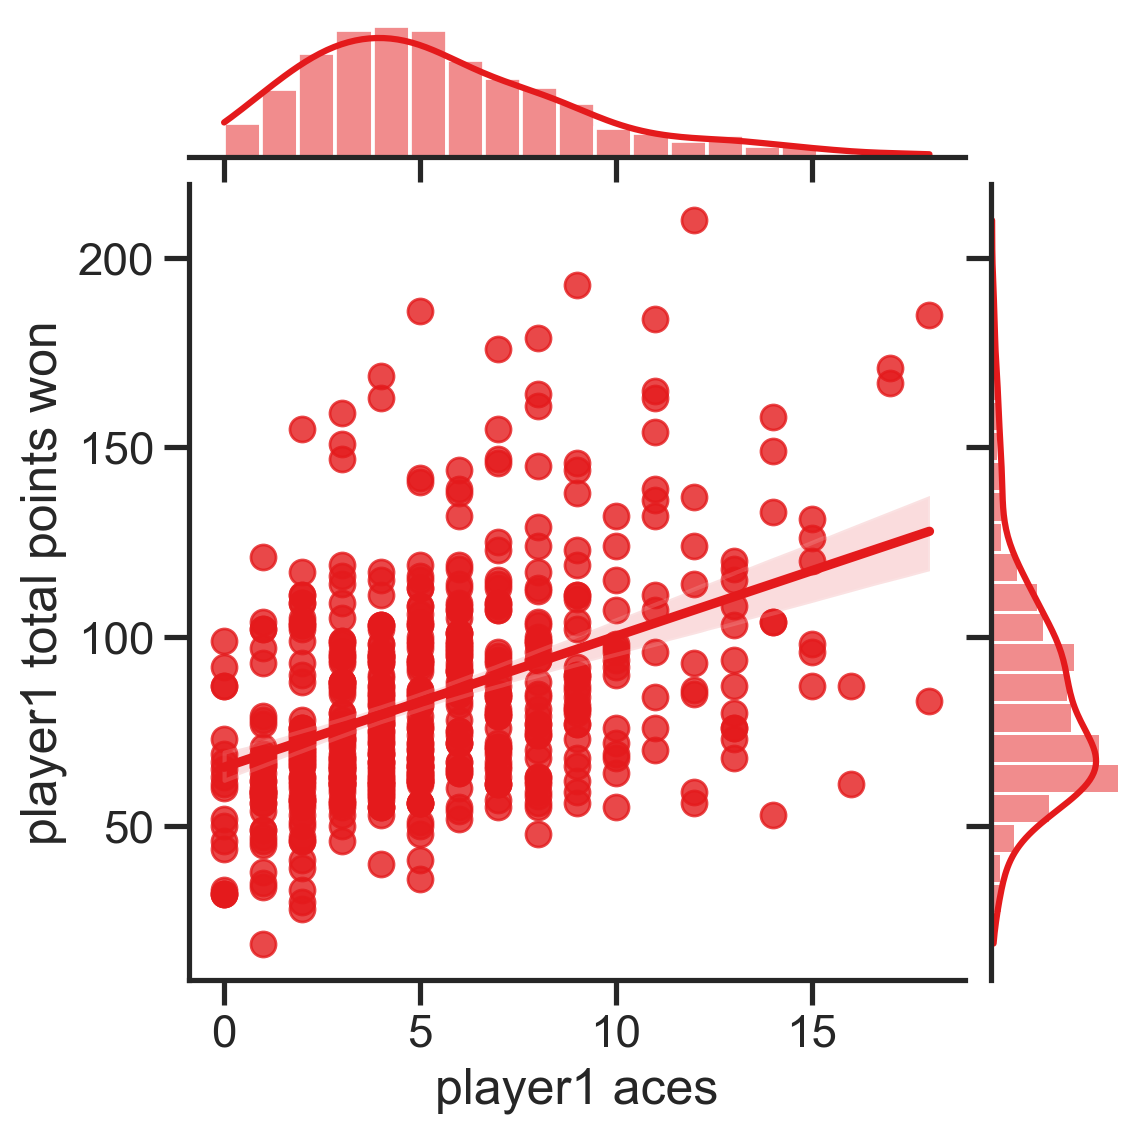

In [6]:
sns.jointplot(x='player1 aces', y='player1 total points won', data=df, kind='reg');

$$
Y = f(X) $$$$
Y \approx g(X)
$$

The simplest model for such predictions is the linear model
$$
\widehat{y} = g(x) = ax + b
$$
where here $x$ is the aces and $y$ is the points won.
The model parameters can be interpreted as follows:
- the intercept $b$ is the estimate for points won if 0 points were aced, and
- the slope $a$ is the estimate for the linear increase in points won for every additional ace.

We then look for $a$ and $b$ such that this loss function is minimized:
$$
loss = \sum_{i=1}^n{(y-\widehat{y})^2}
$$
Note that this loss is just the square of the residuals -- the difference between the true value $y$ and the predicted value $\widehat{y}$.

Let's use Scikit-learn to fit a linear regression model.

We first format the data the way scikit-learn likes it.

In [10]:
X = df['player1 aces'].values
y = df['player1 total points won'].values
# remove NaN
y = y[np.isfinite(X)]
X = X[np.isfinite(X)]

print(X.shape)
X = X.reshape((-1, 1))  # scikit-learn likes X to be 2D, even if there is only one feature
print(X.shape)

(565,)
(565, 1)


In [12]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We then fit the model.

In [15]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
print("R^2: {:.4f}".format(lm.score(X_test, y_test)))

R^2: 0.0672


In [16]:
lm.score(X_train, y_train)

0.2082840847570585

$R^2$ is the proportion of variation in $y$ explained by the linear regression. 6% is not a lot...

However, the plot looks pretty good.

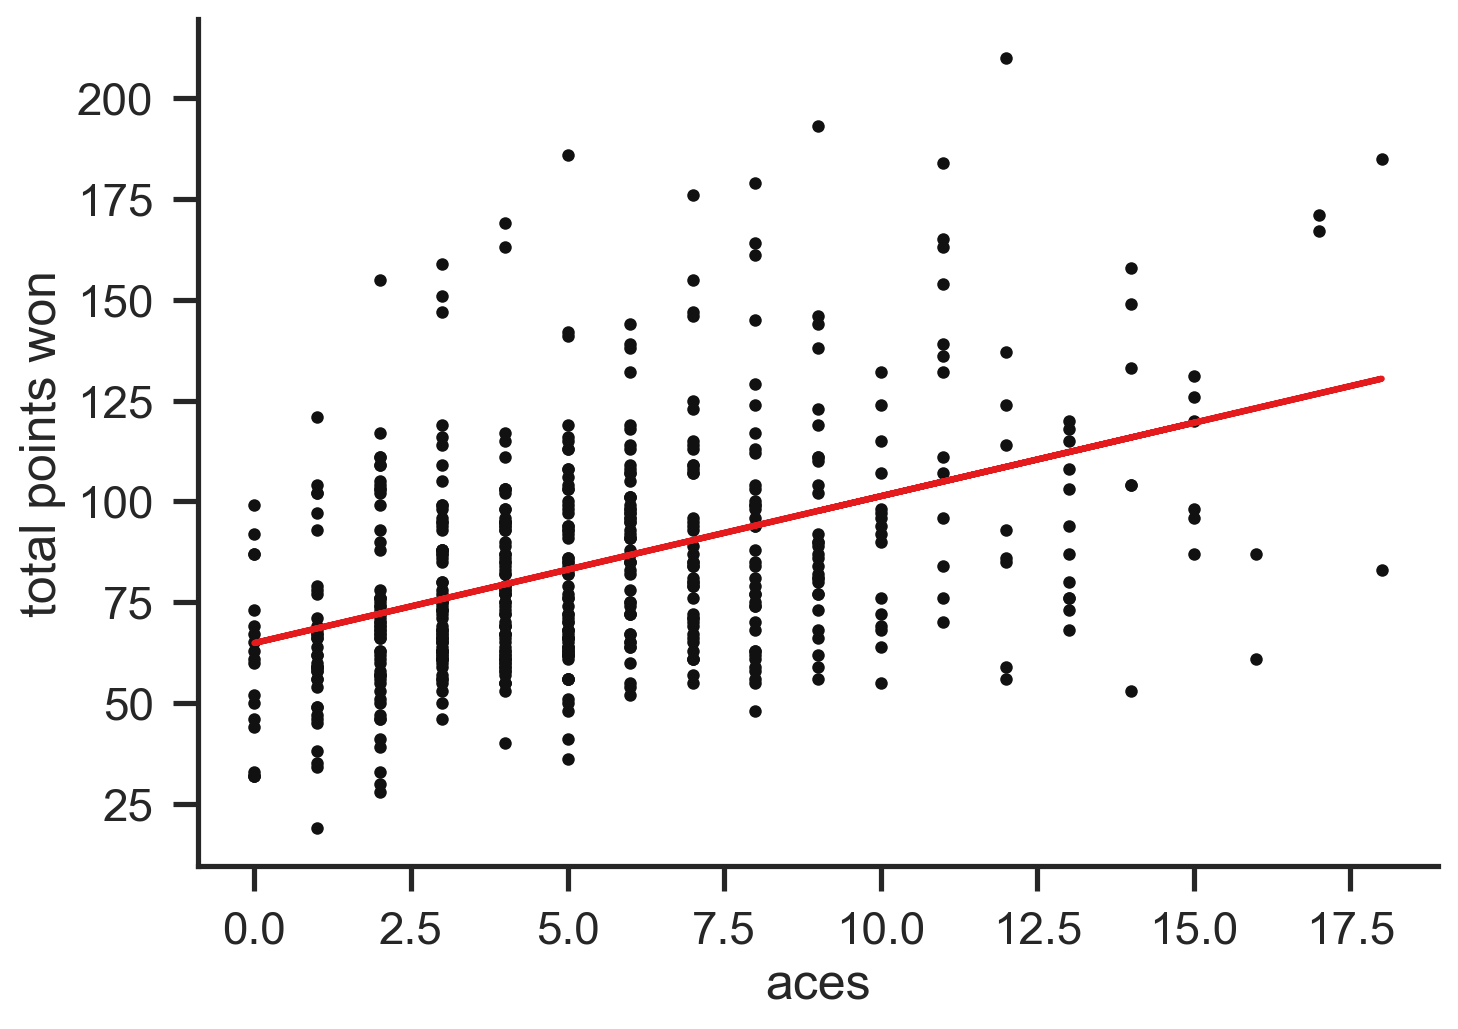

In [11]:
plt.plot(X, y, '.k')
plt.plot(X, lm.predict(X))
plt.xlabel('aces')
plt.ylabel('total points won')
sns.despine()

The slope can be accessed as so:

In [19]:
print('slope:', lm.coef_)

slope: [3.64227561]


# Robust linear regression

There are many outliers in the data - points far away to the top.

We can try a linear regression model that is robust to outliers.
One example is Huber regression.

In [24]:
hub = linear_model.HuberRegressor(epsilon=1)
hub.fit(X_train, y_train)
print("R^2: {:.4f}".format(hub.score(X_test, y_test)))

R^2: 0.0702


The $R^2$ is slightly higher.

What about the line? Let's compare to the standard linear model.

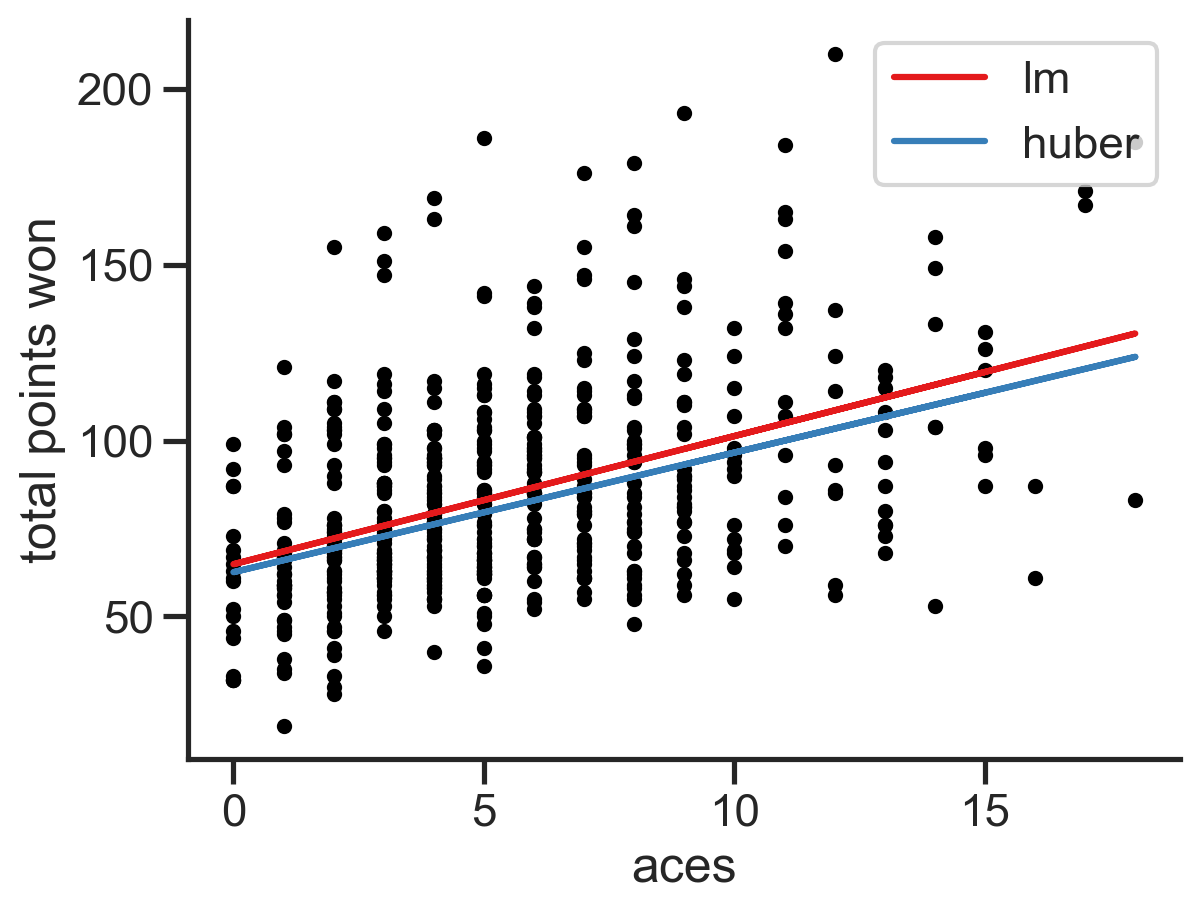

In [25]:
plt.plot(X, y, '.k')
plt.plot(X, lm.predict(X), label='lm')
plt.plot(X, hub.predict(X), label='huber')
plt.xlabel('aces')
plt.ylabel('total points won')
plt.legend()
sns.despine()

You can see that the Huber model is slightly less affected by the high-total matches.

## Exercise: Tennis

Try to choose a different feature that explains the total points won.

# Diabetes: multiple features

Now we try to predict a continuous variable $y$ 

We'll work with the diabetes dataset:
> Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

In [30]:
df = pd.read_csv('../data/diabetes.csv')
features = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X = df[features].values # get the features array
y = df['target'].values  # get the target array
df.head()

age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019908 -0.017646   151.0  
1 -0.039493 -0.068330 -0.092204    75.0  
2 -0.002592  0.002864 -0.025930   141.0  
3  0.034309  0.022692 -0.009362   206.0  
4 -0.002592 -0.031991 -0.046641   135.0

Let's look at the features (`X`):

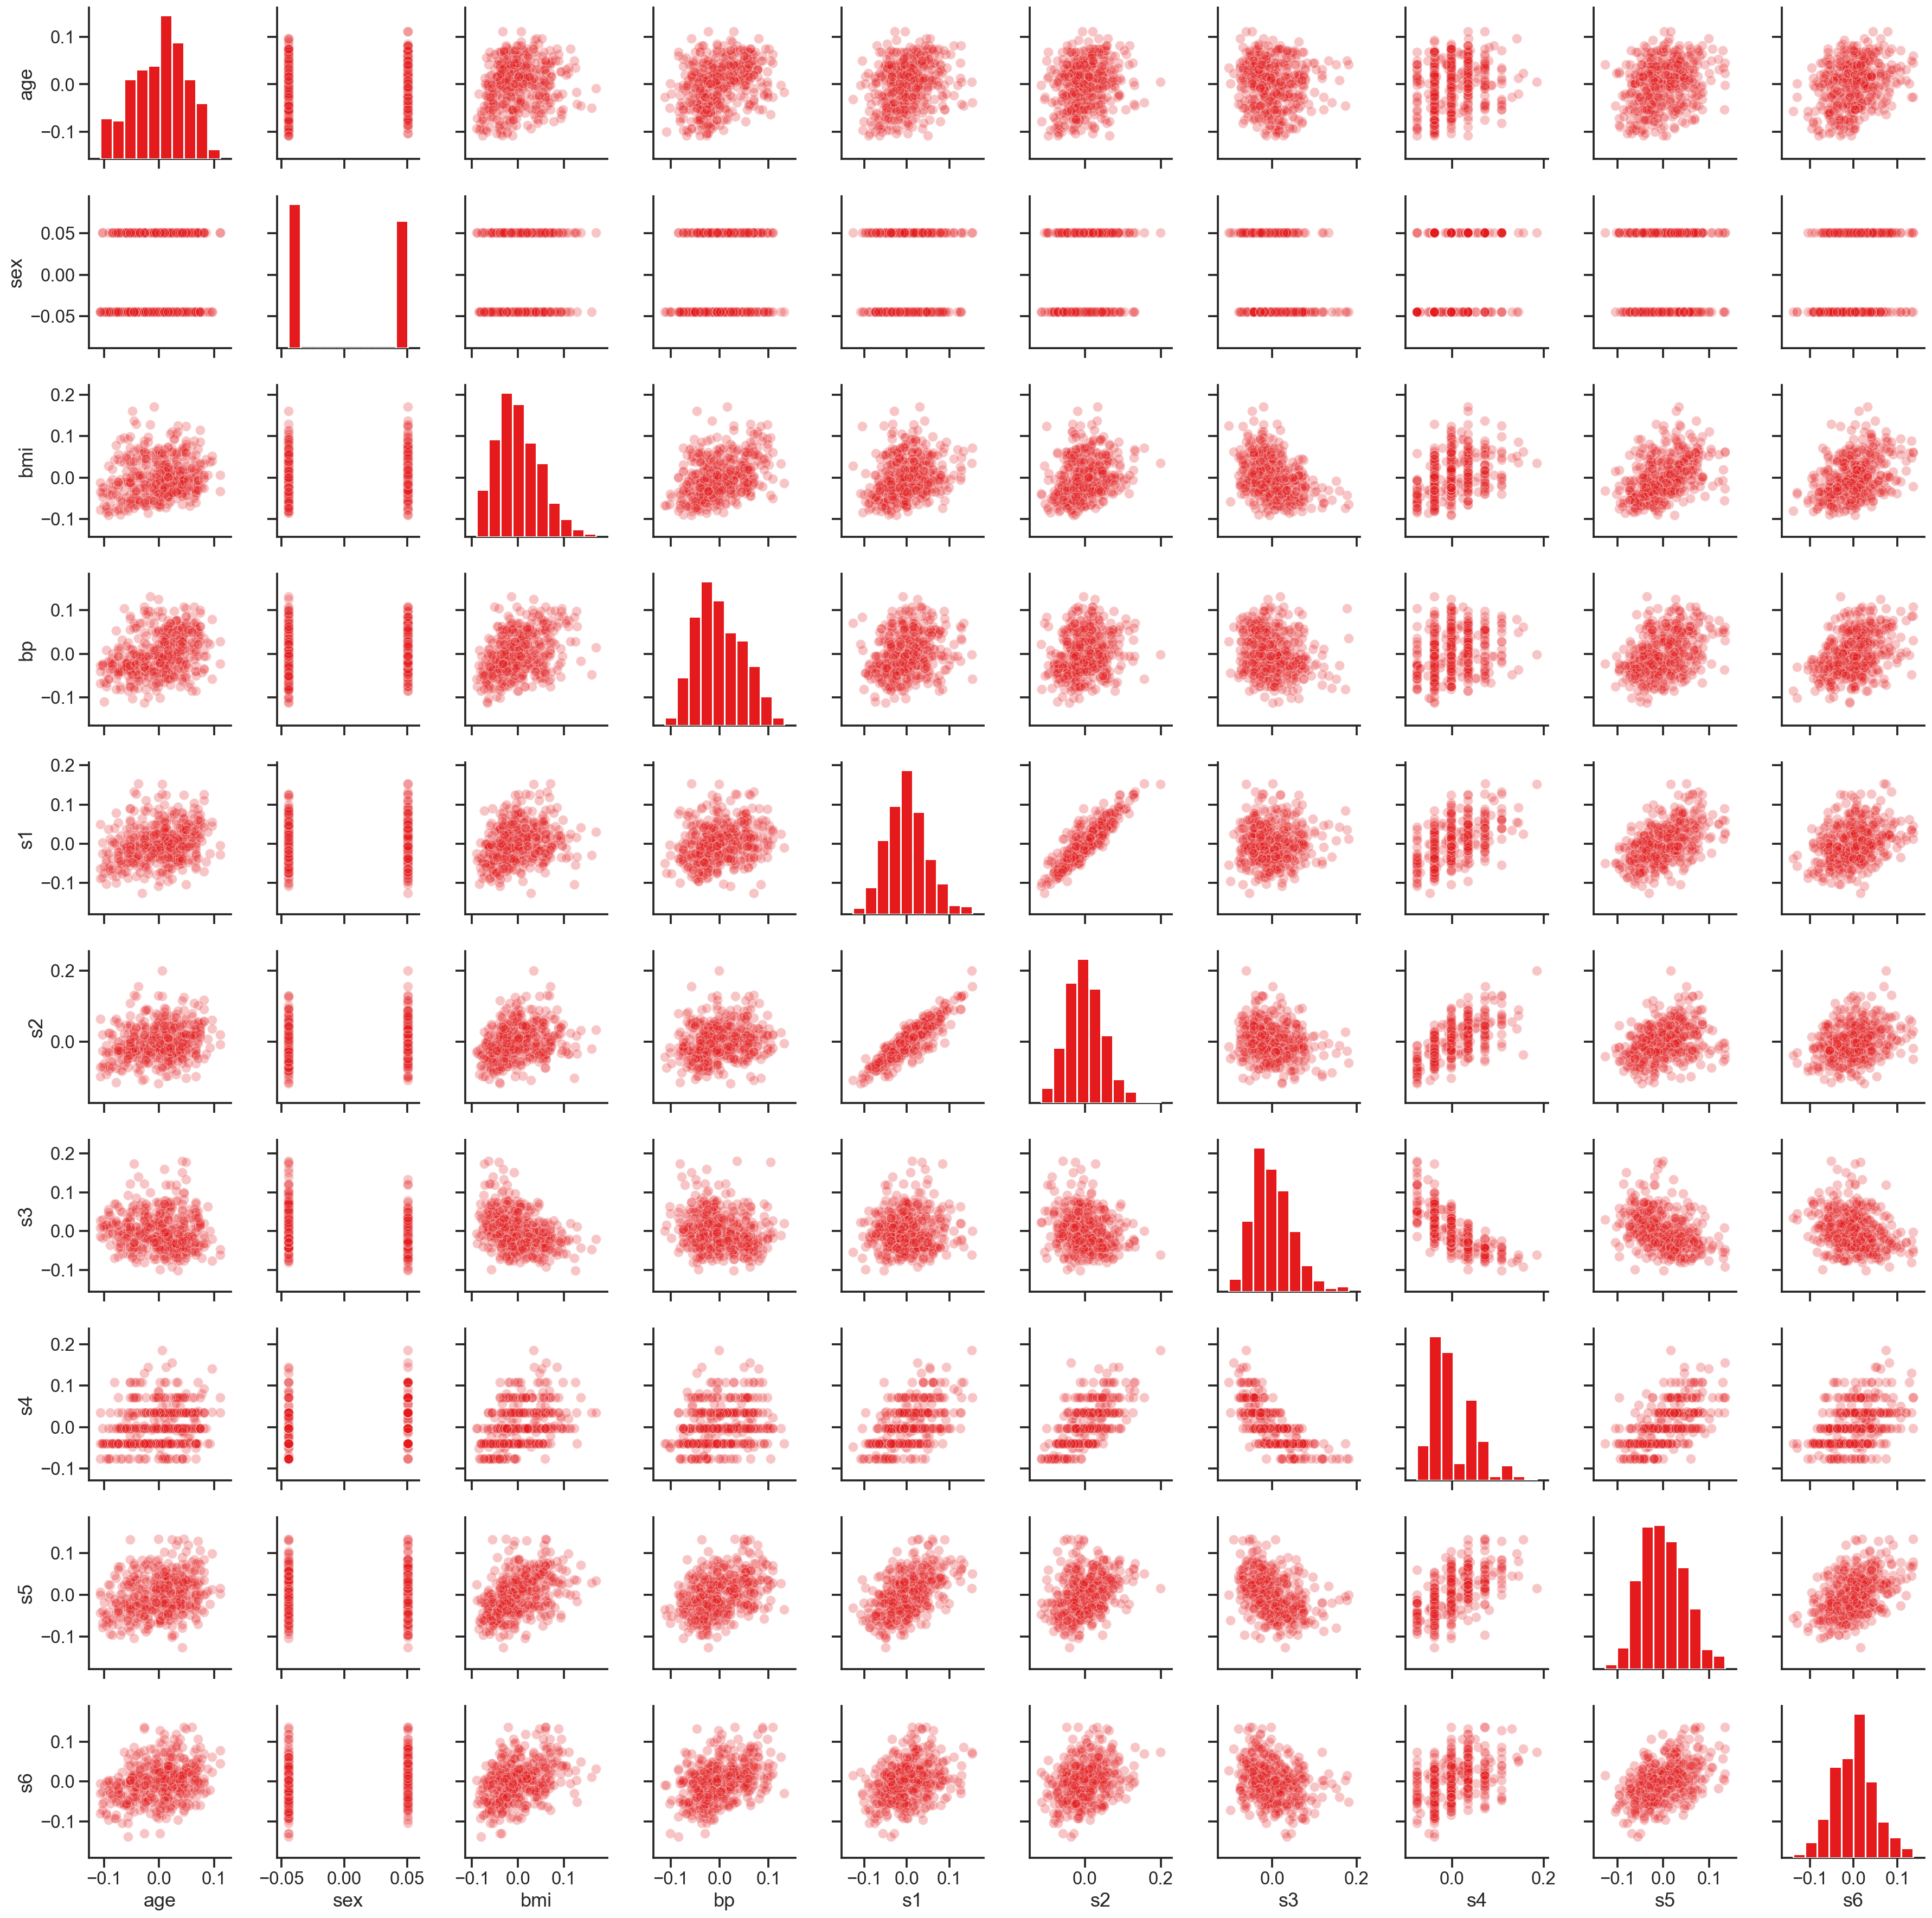

In [21]:
sns.pairplot(df, vars=features, plot_kws=dict(alpha=0.25));

Let's look at the distribution of the targets (`y`):

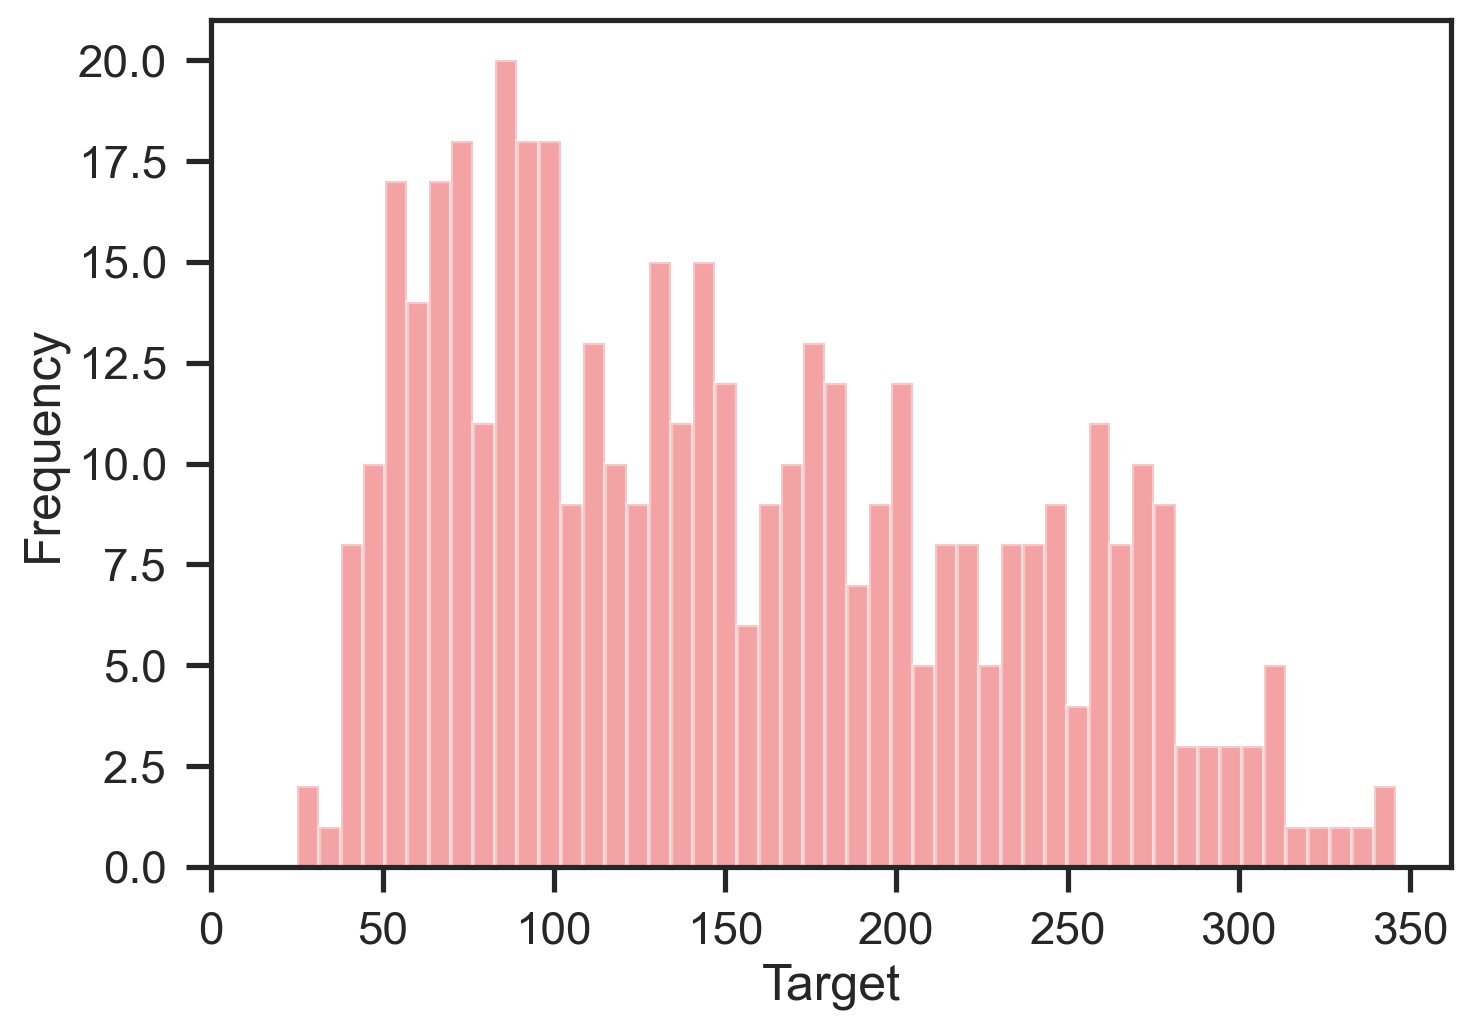

In [16]:
sns.distplot(y, kde=False, bins=50)
plt.xlim(0, None);
plt.xlabel('Target')
plt.ylabel('Frequency');

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
n_features = len(features)

Let's use a linear model to do regression.

We assume that $y$ is a linear function of $x$:

$$ \hat{y} = a_0 + a_1 x_1 + \ldots + a_m x_m $$

We use scikit-learn to find $a_j$ such that the model fit is optimal, that is, the following function is minimized:

$$
f(a_1, \ldots, a_m) = \frac{1}{n} \sum_{i=1}^{n}{(\hat{y}_i - y_i)^2}
$$
where $i$ is the i-th sample out of $n$ samples.

Lets run the regression and print the model score, which is the $R^2$ -- the fraction of variance in the target explained by the model.

In [40]:
regressor = linear_model.LinearRegression()

In [41]:
regressor.fit(X_train, y_train)

score = regressor.score(X_test, y_test)
print('Linear model score: {:.2f}'.format(score))

Linear model score: 0.36


## Diagnostic plots

How good is the model? We can use scikit-learn to produce two related `PredictionErrorDisplay` plots:
- a `residual_vs_predicted` plot shows the residual ($y-\hat{y}$) distribution. Zero residuals are good, and we expect a normal distribution around zero.
- am `actual_vs_predicted` shows the $y$ vs $\hat{y}$ together with a one-to-one line. We would like the markers to be close to the line and the cloud of markers to be roughly symmetric around the line.

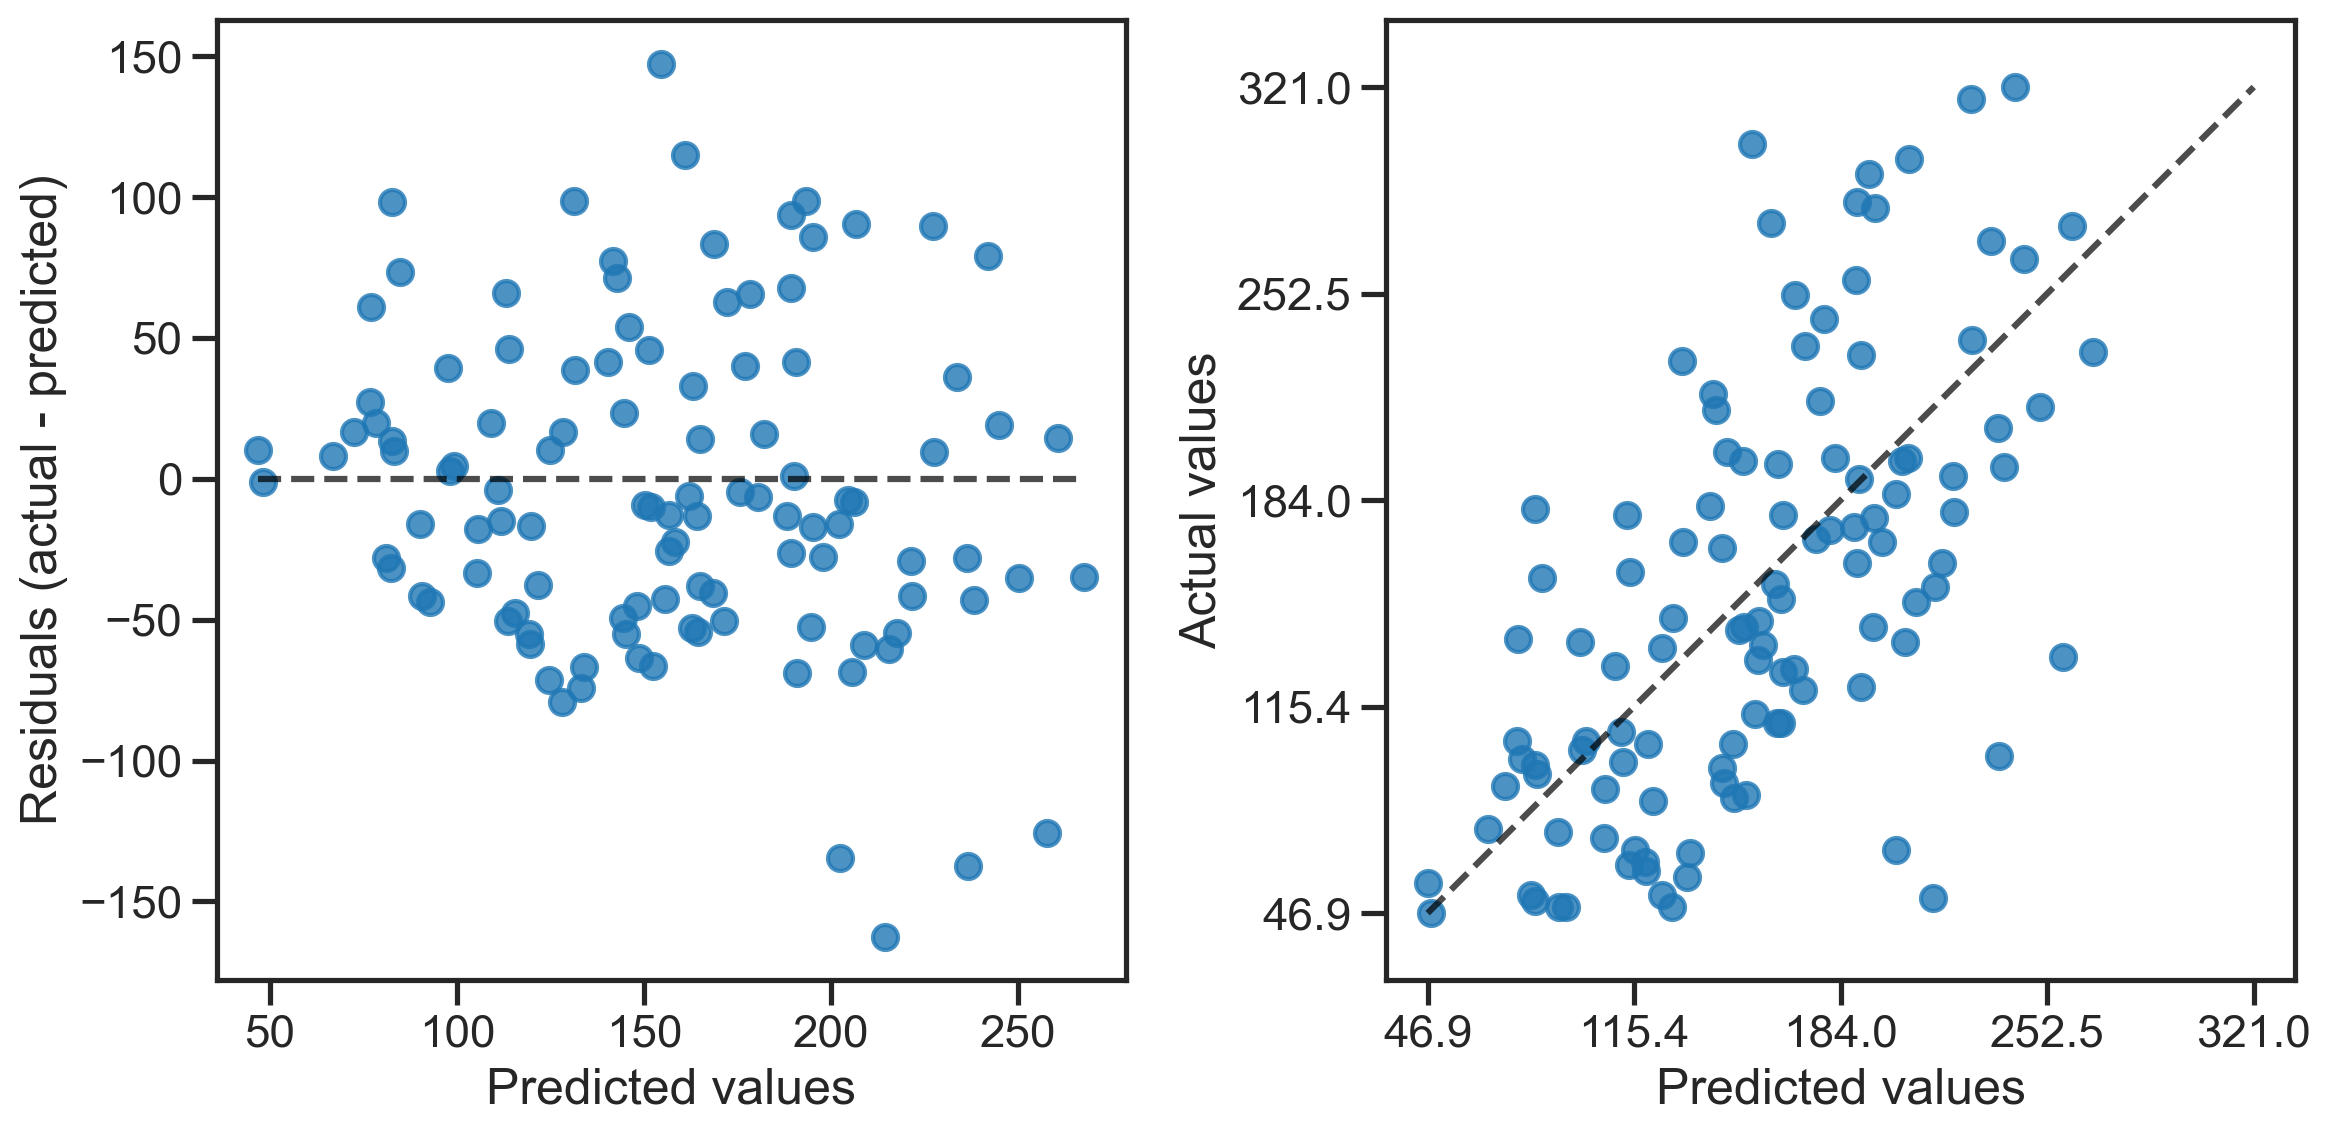

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
PredictionErrorDisplay.from_estimator(regressor, X=X_test, y=y_test, kind="residual_vs_predicted", ax=axes[0])
PredictionErrorDisplay.from_estimator(regressor, X=X_test, y=y_test, kind="actual_vs_predicted", ax=axes[1])
fig.tight_layout()

One of the advantages of a linear model is that we can interpret the coefficients as the contribution of the features to the predicted value.

The following shows us the linear contribution (hight of bar) and direction (color) of each feature.

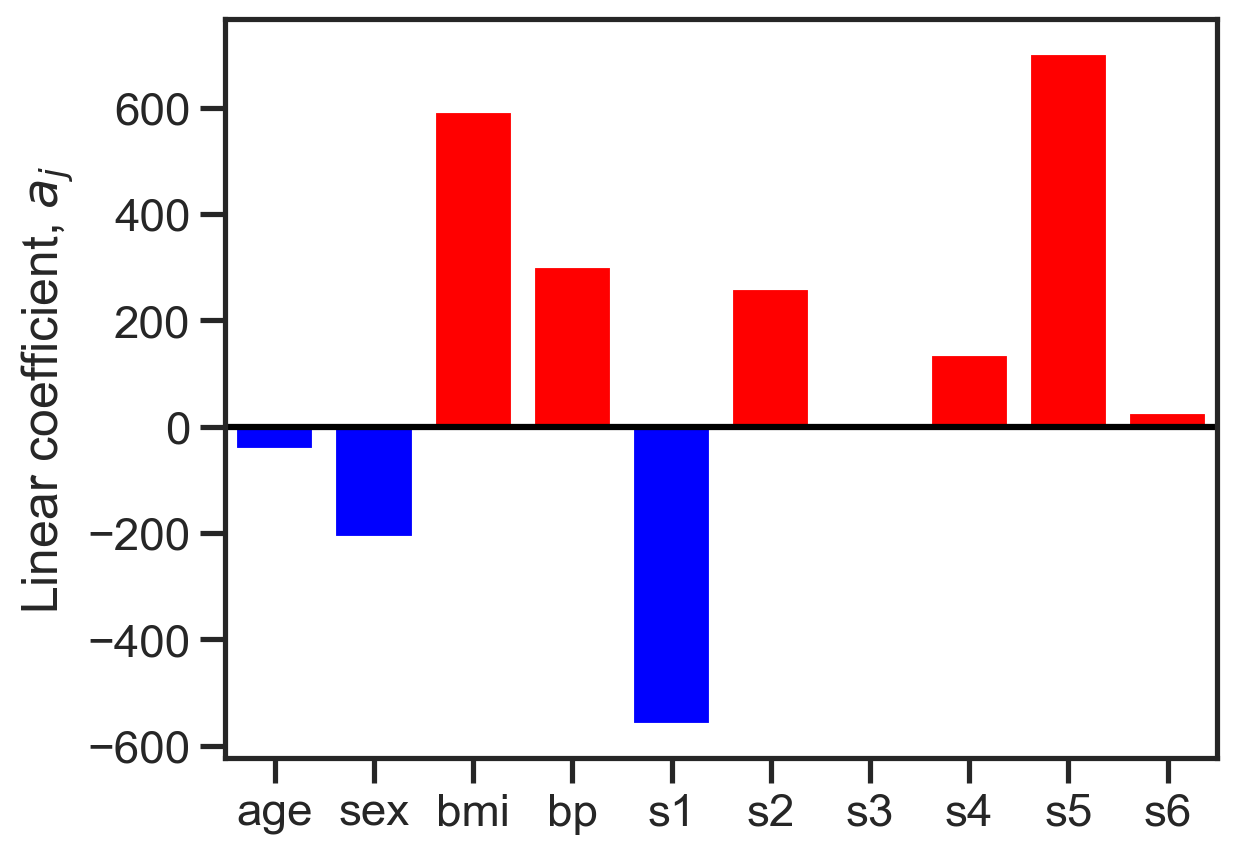

In [37]:
coefs = regressor.coef_
coefs_idx = np.arange(len(coefs))
pos_coefs = coefs > 0
neg_coefs = coefs < 0

fig, ax = plt.subplots()

ax.bar(coefs_idx[pos_coefs], coefs[pos_coefs], color='r')
ax.bar(coefs_idx[neg_coefs], coefs[neg_coefs], color='b')
ax.axhline(0, color='k')
ax.set_ylabel('Linear coefficient, $a_j$');
ax.set_xticks(coefs_idx)
ax.set_xticklabels(features)
ax.set_xlim(-0.5, coefs_idx.max()+0.5);

## Exercise: Lasso

Now experiment with the Lasso model from the `linear_model` package ([Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)): least absolute shrinkage and selection operator).

Lasso is a linear model that performs _regularization_: avoiding giving too much weight to any single feature. 
This is done by minimizing not just the sum of residual squares between the model predictions and the observed values (the fit), but also the sum of the absolute values of the model coefficients (the penalty):

$$
\hat{y} = a_0 + a_1 x_1 + \ldots + a_m x_m $$$$
f(a_1, \ldots, a_m) = \frac{1}{2n} \sum_{i=1}^{n}{(\hat{y}_i - y_i)^2} + \alpha \sum_{j=1}^{m} |a_j|
$$

This is useful for feature selection, that is, finding features that are less important and therefore get a zero coefficeint. 
Thus, is increases prediction accuracy as well as interpretability of the linear model.

A meta-parameter $\alpha$ is used to weight the penalty relative to the fit: the higher $\alpha$, the more weight is given to the penalty.

**Repeat the analysis from above with a Lasso model**.

**Reminder**
- Edit cell by double clicking
- Run cell by pressing _Shift+Enter_
- Get autocompletion by pressing _Tab_
- Get documentation by pressing _Shift+Tab_

Lasso model score: 0.36


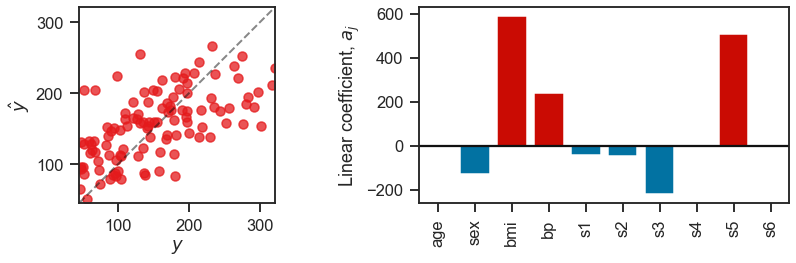

In [51]:
# your code here

# References

- Scikit-learn [supervised learning tutorial](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html).
- [Tuning meta-parameters](http://scikit-learn.org/stable/modules/grid_search.html#grid-search) with cross validation.

# Futher exercise

- [Regression with a linear model](../exercises/linear-model.ipynb)
- [Classification with a logistic model](../exercises/logistic-tennis.ipynb)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)